In [2]:

from google.colab import drive


drive.mount('/content/drive')


Mounted at /content/drive


Spark Install

In [3]:
!pip3 -q install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Uber').master("local[*]").getOrCreate()
sc = spark.sparkContext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [71]:
import math
from pyspark.sql.functions import mean
from pyspark.ml.feature import (VectorAssembler,OneHotEncoder, StringIndexer)
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, sum, year, month, dayofweek, hour, minute, second, date_format, to_date, to_timestamp,when,radians, sin, cos, sqrt, atan2, udf
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler




In [5]:
file_path = '/content/drive/MyDrive/Projects/Uber analysis pyspark/uber.csv'

In [6]:
# Load the data into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [7]:
df.show(5)

+--------+-------------------+-----------+-------------------+------------------+-----------------+------------------+-----------------+---------------+
|     _c0|                key|fare_amount|    pickup_datetime|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|
+--------+-------------------+-----------+-------------------+------------------+-----------------+------------------+-----------------+---------------+
|24238194|2015-05-07 19:52:06|        7.5|2015-05-07 19:52:06|-73.99981689453125|40.73835372924805|   -73.99951171875|40.72321701049805|              1|
|27835199|2009-07-17 20:04:56|        7.7|2009-07-17 20:04:56|        -73.994355|        40.728225|         -73.99471|        40.750325|              1|
|44984355|2009-08-24 21:45:00|       12.9|2009-08-24 21:45:00|        -74.005043|         40.74077|        -73.962565|        40.772647|              1|
|25894730|2009-06-26 08:22:21|        5.3|2009-06-26 08:22:21|        -73.976124| 

In [8]:
df = df.drop('_c0')

In [9]:
df.show(5)

+-------------------+-----------+-------------------+------------------+-----------------+------------------+-----------------+---------------+
|                key|fare_amount|    pickup_datetime|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|
+-------------------+-----------+-------------------+------------------+-----------------+------------------+-----------------+---------------+
|2015-05-07 19:52:06|        7.5|2015-05-07 19:52:06|-73.99981689453125|40.73835372924805|   -73.99951171875|40.72321701049805|              1|
|2009-07-17 20:04:56|        7.7|2009-07-17 20:04:56|        -73.994355|        40.728225|         -73.99471|        40.750325|              1|
|2009-08-24 21:45:00|       12.9|2009-08-24 21:45:00|        -74.005043|         40.74077|        -73.962565|        40.772647|              1|
|2009-06-26 08:22:21|        5.3|2009-06-26 08:22:21|        -73.976124|        40.790844|        -73.965316|        40.803349|         

In [10]:
df.printSchema()

root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [11]:
# List of column expressions to calculate null counts
null_counts_expressions = [sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]


In [12]:
df.select(null_counts_expressions).show()

+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|key|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|  0|          0|              0|               0|              0|                1|               1|              0|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+



In [13]:
df_cleaned = df.dropna()

In [14]:
df_cleaned.select(null_counts_expressions).show() #no null values now

+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|key|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|  0|          0|              0|               0|              0|                0|               0|              0|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+



In [15]:
df_cleaned.count()

199999

In [16]:
# Extract year, month, day of week, hour, minute, and second
df_2 = df_cleaned.withColumn("year", year("pickup_datetime")) \
            .withColumn("month", month("pickup_datetime")) \
            .withColumn("day_of_week", date_format("pickup_datetime", "EEEE")) \
            .withColumn("hour", hour("pickup_datetime")) \
            .withColumn("minute", minute("pickup_datetime")) \
            .withColumn("second", second("pickup_datetime"))

# Show the new DataFrame
df_2.show()


+-------------------+-----------+-------------------+------------------+------------------+------------------+------------------+---------------+----+-----+-----------+----+------+------+
|                key|fare_amount|    pickup_datetime|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|passenger_count|year|month|day_of_week|hour|minute|second|
+-------------------+-----------+-------------------+------------------+------------------+------------------+------------------+---------------+----+-----+-----------+----+------+------+
|2015-05-07 19:52:06|        7.5|2015-05-07 19:52:06|-73.99981689453125| 40.73835372924805|   -73.99951171875| 40.72321701049805|              1|2015|    5|   Thursday|  19|    52|     6|
|2009-07-17 20:04:56|        7.7|2009-07-17 20:04:56|        -73.994355|         40.728225|         -73.99471|         40.750325|              1|2009|    7|     Friday|  20|     4|    56|
|2009-08-24 21:45:00|       12.9|2009-08-24 21:45:00|       

In [17]:
df_2 = df_2.drop('pickup_datetime', 'second')

In [18]:
df_2.show(5)

+-------------------+-----------+------------------+-----------------+------------------+-----------------+---------------+----+-----+-----------+----+------+
|                key|fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|year|month|day_of_week|hour|minute|
+-------------------+-----------+------------------+-----------------+------------------+-----------------+---------------+----+-----+-----------+----+------+
|2015-05-07 19:52:06|        7.5|-73.99981689453125|40.73835372924805|   -73.99951171875|40.72321701049805|              1|2015|    5|   Thursday|  19|    52|
|2009-07-17 20:04:56|        7.7|        -73.994355|        40.728225|         -73.99471|        40.750325|              1|2009|    7|     Friday|  20|     4|
|2009-08-24 21:45:00|       12.9|        -74.005043|         40.74077|        -73.962565|        40.772647|              1|2009|    8|     Monday|  21|    45|
|2009-06-26 08:22:21|        5.3|        -73.9

In [19]:
df_2 = df_2.withColumn("day_or_night",
                   when((df_2["hour"] >= 6) & (df_2["hour"] < 18), "Day")
                   .otherwise("Night"))

In [20]:
df_2.show(5)

+-------------------+-----------+------------------+-----------------+------------------+-----------------+---------------+----+-----+-----------+----+------+------------+
|                key|fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|year|month|day_of_week|hour|minute|day_or_night|
+-------------------+-----------+------------------+-----------------+------------------+-----------------+---------------+----+-----+-----------+----+------+------------+
|2015-05-07 19:52:06|        7.5|-73.99981689453125|40.73835372924805|   -73.99951171875|40.72321701049805|              1|2015|    5|   Thursday|  19|    52|       Night|
|2009-07-17 20:04:56|        7.7|        -73.994355|        40.728225|         -73.99471|        40.750325|              1|2009|    7|     Friday|  20|     4|       Night|
|2009-08-24 21:45:00|       12.9|        -74.005043|         40.74077|        -73.962565|        40.772647|              1|2009|    8|     M

In [21]:
#unique key values
df_2.select(col("key")).distinct().count()

196628

In [22]:
# Define the Haversine formula as a Python function
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Compute differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance

In [23]:
# Convert the Haversine formula to a UDF, The step to convert the Haversine formula to a User Defined Function (UDF) is necessary because
# PySpark requires functions to be registered as UDFs in order to apply them to
# DataFrame columns.
haversine_udf = udf(lambda lat1, lon1, lat2, lon2: haversine(lat1, lon1, lat2, lon2), DoubleType())


In [24]:
# Apply the Haversine formula UDF to calculate distance
df_2 = df_2.withColumn("distance_km", haversine_udf(col("pickup_latitude"), col("dropoff_longitude"), col("dropoff_latitude"), col("dropoff_longitude")))


In [25]:
df_2.show(5)

+-------------------+-----------+------------------+-----------------+------------------+-----------------+---------------+----+-----+-----------+----+------+------------+------------------+
|                key|fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|year|month|day_of_week|hour|minute|day_or_night|       distance_km|
+-------------------+-----------+------------------+-----------------+------------------+-----------------+---------------+----+-----+-----------+----+------+------------+------------------+
|2015-05-07 19:52:06|        7.5|-73.99981689453125|40.73835372924805|   -73.99951171875|40.72321701049805|              1|2015|    5|   Thursday|  19|    52|       Night|1.6831263310455395|
|2009-07-17 20:04:56|        7.7|        -73.994355|        40.728225|         -73.99471|        40.750325|              1|2009|    7|     Friday|  20|     4|       Night|2.4574078788441422|
|2009-08-24 21:45:00|       12.9|        -74.

In [26]:
df_2 = df_2.drop('pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude')

In [27]:
df_2.show(5)

+-------------------+-----------+---------------+----+-----+-----------+----+------+------------+------------------+
|                key|fare_amount|passenger_count|year|month|day_of_week|hour|minute|day_or_night|       distance_km|
+-------------------+-----------+---------------+----+-----+-----------+----+------+------------+------------------+
|2015-05-07 19:52:06|        7.5|              1|2015|    5|   Thursday|  19|    52|       Night|1.6831263310455395|
|2009-07-17 20:04:56|        7.7|              1|2009|    7|     Friday|  20|     4|       Night|2.4574078788441422|
|2009-08-24 21:45:00|       12.9|              1|2009|    8|     Monday|  21|    45|       Night|3.5445606766481967|
|2009-06-26 08:22:21|        5.3|              3|2009|    6|     Friday|   8|    22|         Day|1.3904925576901968|
|2014-08-28 17:47:00|       16.0|              5|2014|    8|   Thursday|  17|    47|         Day| 1.908327331073727|
+-------------------+-----------+---------------+----+-----+----

In [28]:
df_2.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------+------------------+-----------------+------------+------------------+
|summary|       fare_amount|   passenger_count|              year|             month|day_of_week|              hour|           minute|day_or_night|       distance_km|
+-------+------------------+------------------+------------------+------------------+-----------+------------------+-----------------+------------+------------------+
|  count|            199999|            199999|            199999|            199999|     199999|            199999|           199999|      199999|            199999|
|   mean|11.359891549457801|1.6845434227171137|2011.7424337121686| 6.281791408957044|       NULL|13.491387456937284|29.53484767423837|        NULL|11.022020153306086|
| stddev| 9.901759999426826| 1.385994897260366|1.8563995801735673|3.4389333028560847|       NULL| 6.515505282981817|17.33544258365983|        NULL|198.51644851962516

In [29]:
# Fare amount can be seen having negative values, so those need to be removed
negative_fares_count = df.filter(df_2.fare_amount < 0).count()
print(f"Number of negative fare amounts: {negative_fares_count}")

Number of negative fare amounts: 17


In [30]:
# Remove the negative fare values
df_2 = df_2.filter(df_2.fare_amount >= 0)

In [31]:
df_2.describe().show()

+-------+-----------------+------------------+------------------+-----------------+-----------+------------------+-----------------+------------+------------------+
|summary|      fare_amount|   passenger_count|              year|            month|day_of_week|              hour|           minute|day_or_night|       distance_km|
+-------+-----------------+------------------+------------------+-----------------+-----------+------------------+-----------------+------------+------------------+
|  count|           199982|            199982|            199982|           199982|     199982|            199982|           199982|      199982|            199982|
|   mean| 11.3623017071537| 1.684501605144463| 2011.742356812113|6.282045384084568|       NULL|13.491329219629767|29.53425308277745|        NULL|11.000162263673923|
| stddev|9.897102350180035|1.3859769875199464|1.8563171398503726|3.438947668267369|       NULL| 6.515456636796598|17.33565413238889|        NULL|198.26726205048598|
|    min| 

In [32]:
# A lot of the fares are equal to 0 as well, we need to check this number as well
zero_fares_count = df_2.filter(df_2.fare_amount == 0).count()
print(f"Number of zero fare amounts: {zero_fares_count}")


Number of zero fare amounts: 5


In [33]:
# Remove the fare values with 0
df_2 = df_2.filter(df_2.fare_amount > 0)
df_2.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------+------------------+------------------+------------+------------------+
|summary|       fare_amount|   passenger_count|              year|             month|day_of_week|              hour|            minute|day_or_night|       distance_km|
+-------+------------------+------------------+------------------+------------------+-----------+------------------+------------------+------------+------------------+
|  count|            199977|            199977|            199977|            199977|     199977|            199977|            199977|      199977|            199977|
|   mean|11.362585797366751|1.6844887162023632| 2011.742300364542| 6.282142446381334|       NULL|13.491451516924446|29.533901398660845|        NULL|10.977691451089731|
| stddev| 9.897062999907766|1.3859724341034083|1.8562790812738328|3.4389320936774412|       NULL|6.5153827368241535|17.335622715527958|        NULL| 198.0111751

In [34]:
df_2.show()

+-------------------+-----------+---------------+----+-----+-----------+----+------+------------+-------------------+
|                key|fare_amount|passenger_count|year|month|day_of_week|hour|minute|day_or_night|        distance_km|
+-------------------+-----------+---------------+----+-----+-----------+----+------+------------+-------------------+
|2015-05-07 19:52:06|        7.5|              1|2015|    5|   Thursday|  19|    52|       Night| 1.6831263310455395|
|2009-07-17 20:04:56|        7.7|              1|2009|    7|     Friday|  20|     4|       Night| 2.4574078788441422|
|2009-08-24 21:45:00|       12.9|              1|2009|    8|     Monday|  21|    45|       Night| 3.5445606766481967|
|2009-06-26 08:22:21|        5.3|              3|2009|    6|     Friday|   8|    22|         Day| 1.3904925576901968|
|2014-08-28 17:47:00|       16.0|              5|2014|    8|   Thursday|  17|    47|         Day|  1.908327331073727|
|2011-02-12 02:27:09|        4.9|              1|2011|  

Understanding the distributions through a few box plots

In [35]:
import matplotlib.pyplot as plt

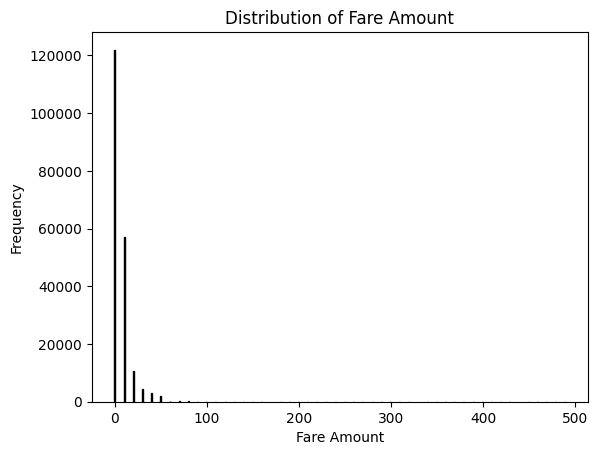

In [36]:
# Collect data for plotting
fare_amount_histogram = df_2.select("fare_amount").rdd.flatMap(lambda x: x).histogram(50)

# Plot histogram
plt.bar(fare_amount_histogram[0][:-1], fare_amount_histogram[1], width=1.0, color='blue', edgecolor='black')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Fare Amount')
plt.show()

In [37]:
# Similarly there are 0's in other columns as well
zero_passenger_count = df_2.filter(df_2.passenger_count == 0).count()
print(f"Number of zero passenger_counts: {zero_passenger_count}")

zero_hour = df_2.filter(df_2.hour == 0).count()
print(f"Number of zero zero_hour: {zero_hour}")

zero_minute = df_2.filter(df_2.minute == 0).count()
print(f"Number of zero zero_minute: {zero_minute}")

zero_distance_km = df_2.filter(df_2.distance_km == 0).count()
print(f"Number of zero zero_distance_km: {zero_distance_km}")

Number of zero passenger_counts: 708
Number of zero zero_hour: 7844
Number of zero zero_minute: 3319
Number of zero zero_distance_km: 5674


In [38]:
# Remove the 0 distance values
df_2 = df_2.filter(df_2.distance_km > 0)
df_2.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------+------------------+------------------+------------+--------------------+
|summary|       fare_amount|   passenger_count|              year|             month|day_of_week|              hour|            minute|day_or_night|         distance_km|
+-------+------------------+------------------+------------------+------------------+-----------+------------------+------------------+------------+--------------------+
|  count|            194303|            194303|            194303|            194303|     194303|            194303|            194303|      194303|              194303|
|   mean|11.353245498010844|1.6848375990077353|2011.7473121876656| 6.281359526100987|       NULL|13.488427867814702| 29.52753174166122|        NULL|  11.298259951285216|
| stddev| 9.738111612989215| 1.388370833494595| 1.860022598800575|3.4403779039239524|       NULL| 6.515061467785387|17.339257082627107|        NULL|  

In [39]:
# Similarly there are 0's in other columns as well
zero_passenger_count = df_2.filter(df_2.passenger_count == 0).count()
print(f"Number of zero passenger_counts: {zero_passenger_count}")

zero_hour = df_2.filter(df_2.hour == 0).count()
print(f"Number of zero zero_hour: {zero_hour}")

zero_minute = df_2.filter(df_2.minute == 0).count()
print(f"Number of zero zero_minute: {zero_minute}")

zero_distance_km = df_2.filter(df_2.distance_km == 0).count()
print(f"Number of zero zero_distance_km: {zero_distance_km}")

Number of zero passenger_counts: 690
Number of zero zero_hour: 7641
Number of zero zero_minute: 3231
Number of zero zero_distance_km: 0


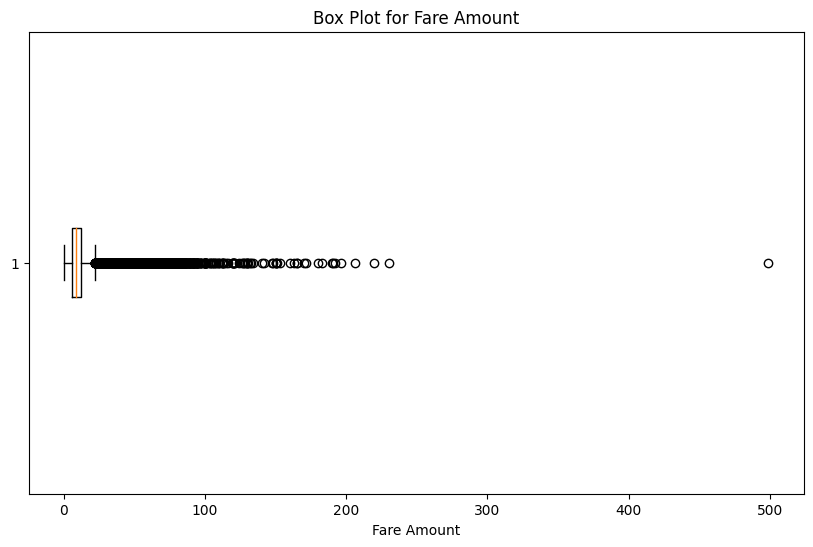

In [40]:
# Lets try checking for outliers to understand the data better
# Collect fare_amount data
fare_amount_data = df_2.select("fare_amount").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.boxplot(fare_amount_data, vert=False)
plt.title('Box Plot for Fare Amount')
plt.xlabel('Fare Amount')
plt.show()

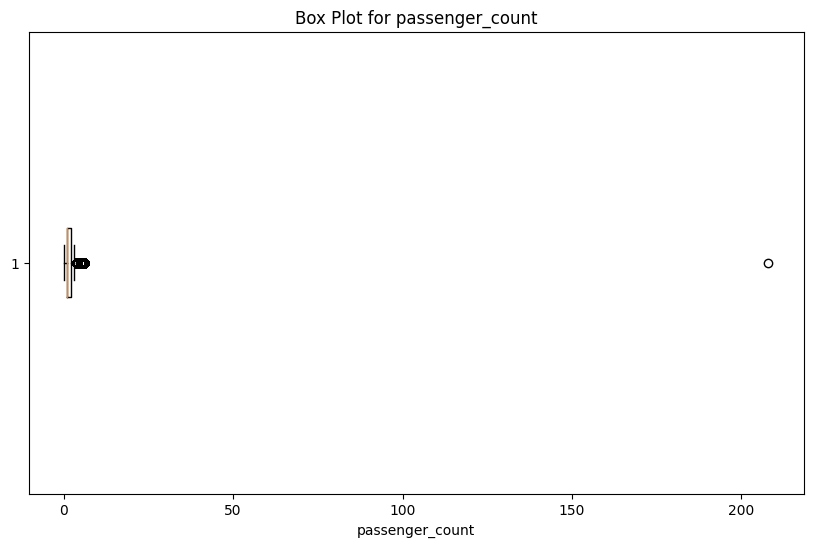

In [41]:
passenger_count_data = df_2.select("passenger_count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.boxplot(passenger_count_data, vert=False)
plt.title('Box Plot for passenger_count')
plt.xlabel('passenger_count')
plt.show()

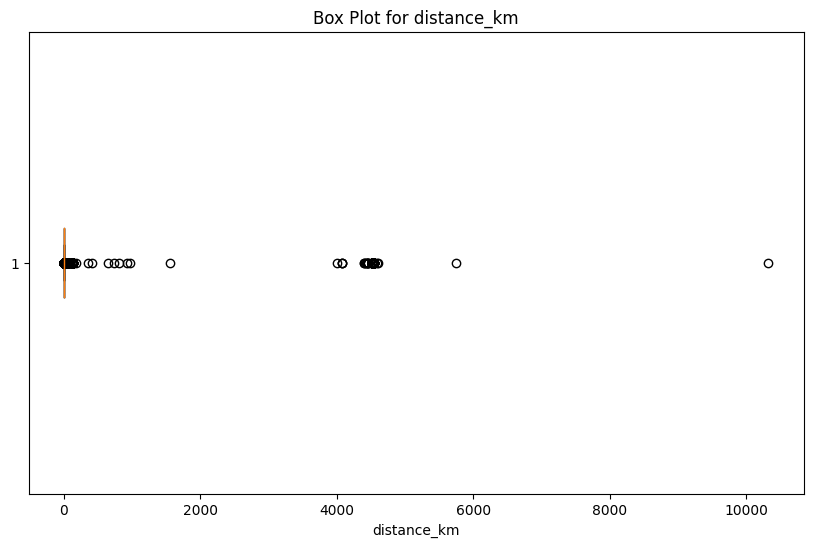

In [42]:
distance_km_data = df_2.select("distance_km").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.boxplot(distance_km_data, vert=False)
plt.title('Box Plot for distance_km')
plt.xlabel('distance_km')
plt.show()

Cleaning the data bsed on certail rules-

Dropping Rows Based on Conditions:
Conditions:

*   Distance > 200
*   Number of passengers < 1 or > 4
*   Fare amount > 100

In [43]:
# Apply filters to remove rows with distance > 200, passenger_count < 1 or > 4, and fare_amount > 100
df_2 = df_2.filter(
    (df_2.distance_km <= 200) &
    (df_2.passenger_count >= 1) &
    (df_2.passenger_count <= 4) &
    (df_2.fare_amount <= 100)
)


In [44]:
#Drop the hour and minute as it will add no value
df_2 = df_2.drop('hour', 'minute','key')

In [45]:
df_2.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------+------------+--------------------+
|summary|       fare_amount|   passenger_count|              year|             month|day_of_week|day_or_night|         distance_km|
+-------+------------------+------------------+------------------+------------------+-----------+------------+--------------------+
|  count|            175447|            175447|            175447|            175447|     175447|      175447|              175447|
|   mean|11.292353930246655|1.3320603943071128|2011.7425262329934|6.2780155830535715|       NULL|        NULL|   2.408416527794775|
| stddev| 9.364558601320052|0.6796615474054641| 1.862745435493951|3.4392762269779995|       NULL|        NULL|  3.0579252908012533|
|    min|              0.01|                 1|              2009|                 1|     Friday|         Day|1.111949256695776...|
|    max|             100.0|                 4|              2015|          

In [46]:
# Adding an extra column for weekend
df_2 = df_2.withColumn("weekend",
                       when((df_2["day_of_week"] == 'Saturday') | (df_2["day_of_week"] == 'Sunday'), 1)
                       .otherwise(0))

In [47]:
df_2.show(5)

+-----------+---------------+----+-----+-----------+------------+------------------+-------+
|fare_amount|passenger_count|year|month|day_of_week|day_or_night|       distance_km|weekend|
+-----------+---------------+----+-----+-----------+------------+------------------+-------+
|        7.5|              1|2015|    5|   Thursday|       Night|1.6831263310455395|      0|
|        7.7|              1|2009|    7|     Friday|       Night|2.4574078788441422|      0|
|       12.9|              1|2009|    8|     Monday|       Night|3.5445606766481967|      0|
|        5.3|              3|2009|    6|     Friday|         Day|1.3904925576901968|      0|
|        9.7|              1|2012|    2|     Friday|         Day|0.2479646864181767|      0|
+-----------+---------------+----+-----+-----------+------------+------------------+-------+
only showing top 5 rows



Encoding the categorical variables

In [48]:
# Indexing day_or_night
indexer_day_or_night = StringIndexer(inputCol="day_or_night", outputCol="day_or_night_index")

# One-hot encoding day_or_night
encoder_day_or_night = OneHotEncoder(inputCol="day_or_night_index", outputCol="day_or_night_encoded")

# Indexing day_of_week
indexer_day_of_week = StringIndexer(inputCol="day_of_week", outputCol="day_of_week_index")

# One-hot encoding day_of_week
encoder_day_of_week = OneHotEncoder(inputCol="day_of_week_index", outputCol="day_of_week_encoded")

# Create a pipeline for both indexers and encoders
pipeline = Pipeline(stages=[indexer_day_of_week, encoder_day_of_week,
                            indexer_day_or_night, encoder_day_or_night])

# Fit and transform the DataFrame
df_2 = pipeline.fit(df_2).transform(df_2)


In [49]:
df_2 = df_2.drop('day_of_week_index','day_or_night_encoded','day_or_night','day_of_week')

In [50]:
df_2.describe().show()

+-------+------------------+------------------+------------------+------------------+--------------------+------------------+-------------------+
|summary|       fare_amount|   passenger_count|              year|             month|         distance_km|           weekend| day_or_night_index|
+-------+------------------+------------------+------------------+------------------+--------------------+------------------+-------------------+
|  count|            175447|            175447|            175447|            175447|              175447|            175447|             175447|
|   mean|11.292353930246655|1.3320603943071128|2011.7425262329934|6.2780155830535715|   2.408416527794775|0.2829173482590184| 0.4721083860083102|
| stddev| 9.364558601320052|0.6796615474054641| 1.862745435493951|3.4392762269779995|  3.0579252908012533|0.4504178933529428|0.49922287445060154|
|    min|              0.01|                 1|              2009|                 1|1.111949256695776...|                 0

In [62]:
df_2.show(5)

+-----------+---------------+----+-----+------------------+-------+-------------------+------------------+
|fare_amount|passenger_count|year|month|       distance_km|weekend|day_of_week_encoded|day_or_night_index|
+-----------+---------------+----+-----+------------------+-------+-------------------+------------------+
|        7.5|              1|2015|    5|1.6831263310455395|      0|      (6,[2],[1.0])|               1.0|
|        7.7|              1|2009|    7|2.4574078788441422|      0|      (6,[0],[1.0])|               1.0|
|       12.9|              1|2009|    8|3.5445606766481967|      0|          (6,[],[])|               1.0|
|        5.3|              3|2009|    6|1.3904925576901968|      0|      (6,[0],[1.0])|               0.0|
|        9.7|              1|2012|    2|0.2479646864181767|      0|      (6,[0],[1.0])|               0.0|
+-----------+---------------+----+-----+------------------+-------+-------------------+------------------+
only showing top 5 rows



In [63]:
# Transform the 'year' column to keep only the last two digits
df_2 = df_2.withColumn("year", col("year") % 100)

In [74]:
df_2.show(5)

+-----------+---------------+----+-----+------------------+-------+-------------------+------------------+
|fare_amount|passenger_count|year|month|       distance_km|weekend|day_of_week_encoded|day_or_night_index|
+-----------+---------------+----+-----+------------------+-------+-------------------+------------------+
|        7.5|              1|  15|    5|1.6831263310455395|      0|      (6,[2],[1.0])|               1.0|
|        7.7|              1|   9|    7|2.4574078788441422|      0|      (6,[0],[1.0])|               1.0|
|       12.9|              1|   9|    8|3.5445606766481967|      0|          (6,[],[])|               1.0|
|        5.3|              3|   9|    6|1.3904925576901968|      0|      (6,[0],[1.0])|               0.0|
|        9.7|              1|  12|    2|0.2479646864181767|      0|      (6,[0],[1.0])|               0.0|
+-----------+---------------+----+-----+------------------+-------+-------------------+------------------+
only showing top 5 rows



In [75]:
# Define the input features you want to scale
input_features = ["passenger_count", "year", "month", "distance_km", "weekend", "day_of_week_encoded", "day_or_night_index"]

# Assemble the features into a single vector
assembler = VectorAssembler(inputCols=input_features, outputCol="features_unscaled")

# Transform the DataFrame
df_assembled = assembler.transform(df_2)

# Initialize the StandardScaler
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features_scaled", withMean=True, withStd=True)

# Fit the scaler on the assembled data
scaler_model = scaler.fit(df_assembled)

# Transform the DataFrame to scale the features
df_final = scaler_model.transform(df_assembled)

# Show the scaled features
df_final.select("features_scaled").show(5, truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features_scaled                                                                                                                                                                                                                                      |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-0.48856728113384945,1.7487487581161174,-0.37159434099205796,-0.23718375296187363,-0.6281219117494672,-0.42799676139869286,-0.4218555104691722,2.378930183873668,-0.41204159250257966,-0.40460237898351287,-0.38969353737436563,1.0574267346475987] |
|[-0.488

In [76]:
df_final.show(5)

+-----------+---------------+----+-----+------------------+-------+-------------------+------------------+--------------------+--------------------+
|fare_amount|passenger_count|year|month|       distance_km|weekend|day_of_week_encoded|day_or_night_index|   features_unscaled|     features_scaled|
+-----------+---------------+----+-----+------------------+-------+-------------------+------------------+--------------------+--------------------+
|        7.5|              1|  15|    5|1.6831263310455395|      0|      (6,[2],[1.0])|               1.0|(12,[0,1,2,3,7,11...|[-0.4885672811338...|
|        7.7|              1|   9|    7|2.4574078788441422|      0|      (6,[0],[1.0])|               1.0|(12,[0,1,2,3,5,11...|[-0.4885672811338...|
|       12.9|              1|   9|    8|3.5445606766481967|      0|          (6,[],[])|               1.0|(12,[0,1,2,3,11],...|[-0.4885672811338...|
|        5.3|              3|   9|    6|1.3904925576901968|      0|      (6,[0],[1.0])|               0.0|

In [79]:
# Split the data into training (70%) and testing (30%)
train_df, test_df = df_final.randomSplit([0.7, 0.3], seed=42)


In [80]:
# Initialize the Linear Regression model
lr = LinearRegression(featuresCol="features_scaled", labelCol="fare_amount")

# Train the model
lr_model = lr.fit(train_df)

# Make predictions on the test data
predictions_lr = lr_model.transform(test_df)


In [81]:
# Initialize Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol="features_scaled", labelCol="fare_amount")

# Train the model
dt_model = dt.fit(train_df)

# Make predictions
predictions_dt = dt_model.transform(test_df)

In [82]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features_scaled", labelCol="fare_amount")

# Train the model
rf_model = rf.fit(train_df)

# Make predictions
predictions_rf = rf_model.transform(test_df)

In [83]:
# Initialize the evaluator for regression models
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")

# Calculate RMSE (Root Mean Squared Error)
rmse_lr = evaluator.evaluate(predictions_lr)
print(f"Root Mean Squared Error for Linear Regression(RMSE): {rmse_lr}")
# Calculate R-squared (R²)
r2_lr = evaluator.evaluate(predictions_lr, {evaluator.metricName: "r2"})
print(f"R-squared for Linear Regression(R²): {r2_lr}")

# Calculate RMSE (Root Mean Squared Error)
rmse_dt = evaluator.evaluate(predictions_dt)
print(f"Root Mean Squared Error for Decision Tree Regression(RMSE): {rmse_dt}")
# Calculate R-squared (R²)
r2_dt = evaluator.evaluate(predictions_dt, {evaluator.metricName: "r2"})
print(f"R-squared for Decision Tree Regression(R²): {r2_dt}")

# Calculate RMSE (Root Mean Squared Error)
rmse_rf = evaluator.evaluate(predictions_rf)
print(f"Root Mean Squared Error for Random Forest Regression(RMSE): {rmse_rf}")
# Calculate R-squared (R²)
r2_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "r2"})
print(f"R-squared for Random Forest Regression(R²): {r2_rf}")


Root Mean Squared Error for Linear Regression(RMSE): 7.612679268421011
R-squared for Linear Regression(R²): 0.34224972127220576
Root Mean Squared Error for Decision Tree Regression(RMSE): 6.638391872172292
R-squared for Decision Tree Regression(R²): 0.4998367864846992
Root Mean Squared Error for Random Forest Regression(RMSE): 6.856987320632243
R-squared for Random Forest Regression(R²): 0.4663547255876871
